In [1]:
import os
import csv
from functools import partial
import glob
import math

from scipy.io import loadmat
import scipy
import ruptures as rpt
from hampel import hampel
import pandas as pd


import numpy as np 

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import PercentFormatter

import matplotlib.mlab as mlab

import seaborn as sns

In [2]:
noisy_mats  = glob.glob('../../../datasets/Data_27012021_noisy/real_noimpulse/OFVC4kW*mat')
noisy_mats.sort()

print (noisy_mats)

['../../../datasets/Data_27012021_noisy/real_noimpulse/OFVC4kW_LM10Hz_paliers_0to120PercTnom_Data.mat', '../../../datasets/Data_27012021_noisy/real_noimpulse/OFVC4kW_LM20Hz_TorqueSteps_20190419_Data.mat', '../../../datasets/Data_27012021_noisy/real_noimpulse/OFVC4kW_LM30Hz_paliers_0to120PercTnom_Data.mat', '../../../datasets/Data_27012021_noisy/real_noimpulse/OFVC4kW_LM45Hz_TorqueSteps_20190419_Data.mat', '../../../datasets/Data_27012021_noisy/real_noimpulse/OFVC4kW_LM50Hz_paliers_0to120PercTnom_Data.mat', '../../../datasets/Data_27012021_noisy/real_noimpulse/OFVC4kW_LM60Hz_TorqueSteps_20190419_Data.mat', '../../../datasets/Data_27012021_noisy/real_noimpulse/OFVC4kW_LM68Hz_paliers_0to120PercTnom_Data.mat', '../../../datasets/Data_27012021_noisy/real_noimpulse/OFVC4kW_NoLM_SpeedVariations2_20190419_Data.mat', '../../../datasets/Data_27012021_noisy/real_noimpulse/OFVC4kW_NoLM_SpeedVariations_20190419_Data.mat', '../../../datasets/Data_27012021_noisy/real_noimpulse/OFVC4kW_NoLM_paliers_0t

In [3]:
current_d = []
current_q = []
voltage_d = []
voltage_q = []
speed = []
torque = []


def get_noise(signal, locs, thr=2):
    noise = []

    for loc in locs:
        part = np.copy(signal[int(loc[0]): int(loc[1])])
        part = np.delete(part, np.where(part < part[0] - thr))
        part = np.delete(part, np.where(part > part[0] + thr))
        mean = np.mean(part)
        noise += list(part - mean)
  
    return noise

def get_stats(path): 
    data = loadmat(path)
    mask = np.zeros(data['time'].shape[1])
    
    speed_r = csv.reader(open(path.replace('.mat', '_speed.csv'), 'r'), delimiter='\t')
    for row in speed_r:
        mask[int(row[0]):int(row[1])] = 1
        
    torque_r = csv.reader(open(path.replace('.mat', '_torque.csv'), 'r'), delimiter='\t')
    for row in torque_r:
        mask[int(row[0]):int(row[1])] = 1
    
    segs = []
    pair = []
    enter = False
    for i in range(0, mask.shape[0]):
        if mask[i] == 0 and not enter:
            enter = True
            pair.append(i)
        if mask[i] == 1 and enter:
            enter = False
            pair.append(i-1)
            segs.append(pair)
            pair = []
            
    return segs, mask
        
for mat_file in noisy_mats:
# mat_file = noisy_mats[2]
    noisy_mat = loadmat(mat_file)
    segs, mask = get_stats(mat_file)

    current_d += get_noise(noisy_mat['noisy_current_d'][0], segs, 0.5)
    current_q += get_noise(noisy_mat['noisy_current_q'][0], segs, 1)
    voltage_d += get_noise(noisy_mat['noisy_voltage_d'][0], segs, 5)
    voltage_q += get_noise(noisy_mat['noisy_voltage_q'][0], segs, 5)
#     speed += get_noise(noisy_mat['noisy_speed'][0], segs, 5)
#     torque += get_noise(noisy_mat['noisy_speed'][0], segs, 10)


current_d = np.asarray(current_d)
current_q = np.asarray(current_q)
voltage_d = np.asarray(voltage_d)
voltage_q = np.asarray(voltage_q)
# speed = np.asarray(speed)
# torque = np.asarray(torque)


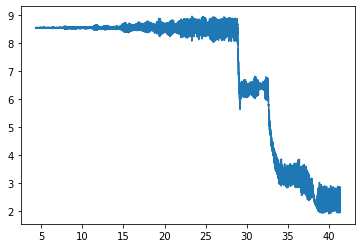

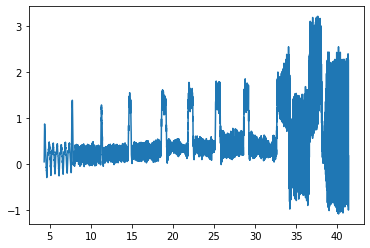

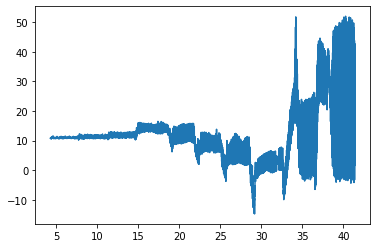

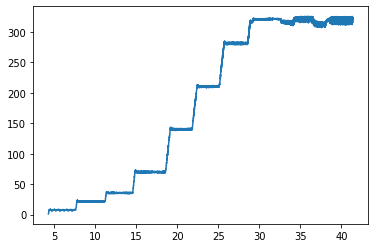

In [4]:
noisy_mat = loadmat(noisy_mats[9])
plt.plot(noisy_mat['time'][0], noisy_mat['noisy_current_d'][0])
plt.show()
plt.plot(noisy_mat['time'][0], noisy_mat['noisy_current_q'][0])
plt.show()
plt.plot(noisy_mat['time'][0], noisy_mat['noisy_voltage_d'][0])
plt.show()
plt.plot(noisy_mat['time'][0], noisy_mat['noisy_voltage_q'][0])
plt.show()

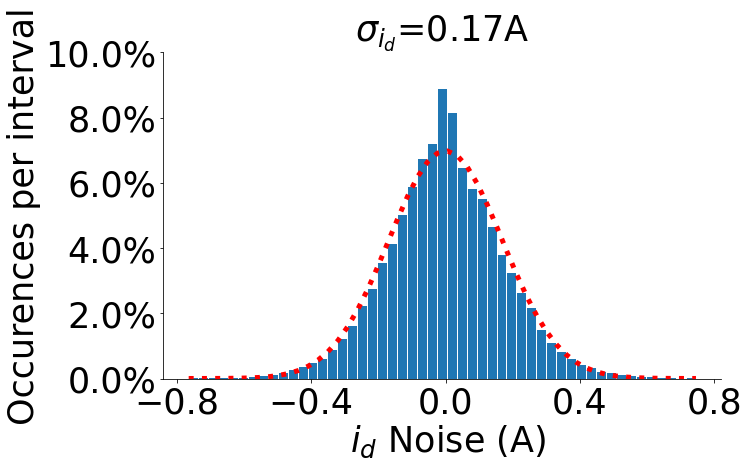

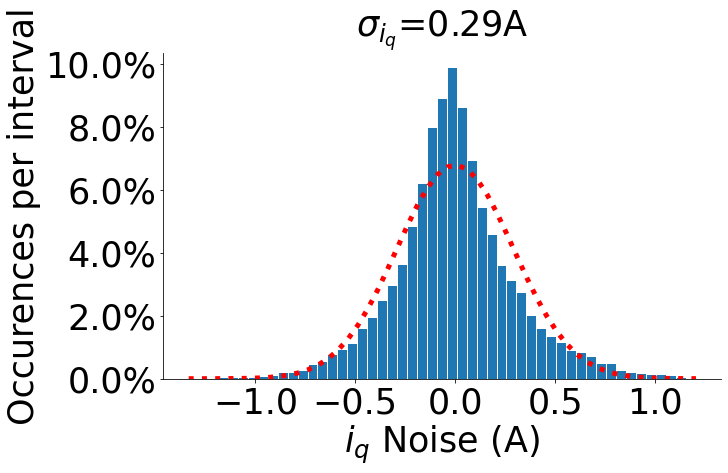

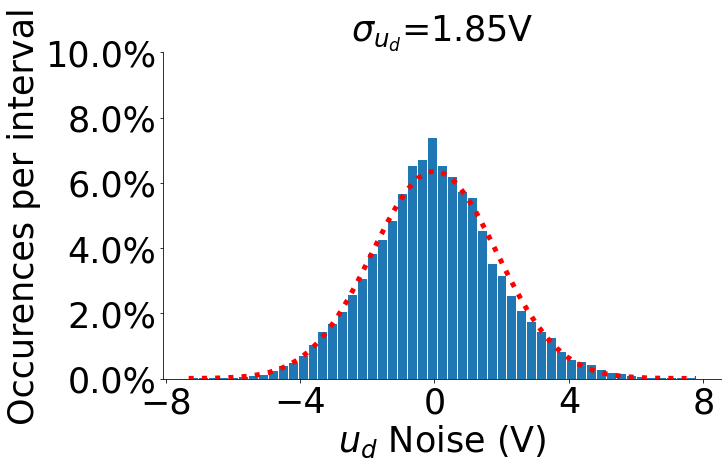

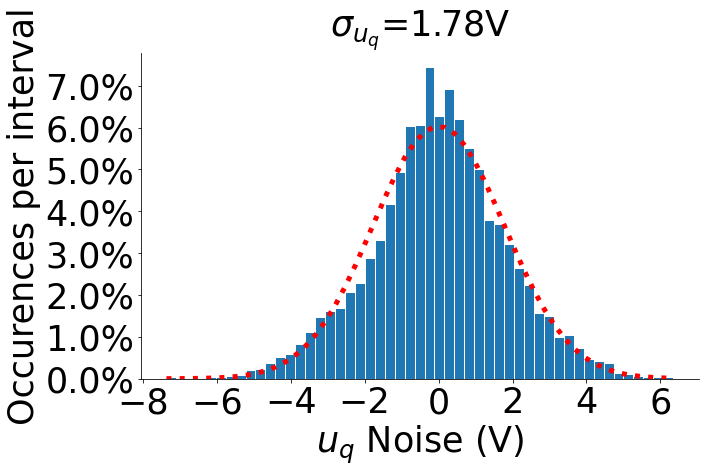

In [8]:
def to_percent(y, position, n):
    s = str(int(round(100 * y / n, 0)))

    if matplotlib.rcParams['text.usetex']:
        return s + r'$\%$'

    return s + '%'

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

bins = 51
# sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10,6))
n, xbins, _ = ax.hist(current_d, bins=bins, rwidth=0.9, density=False, stacked=False, weights=np.ones(len(current_d)) / len(current_d))

mu, sigma = scipy.stats.norm.fit(current_d)
best_fit_line = scipy.stats.norm.pdf(xbins, mu, sigma) * (xbins[1] - xbins[0])
plt.plot(xbins, best_fit_line, 'r:', linewidth=5)


# percent_formatter = partial(to_percent,
#                                 n=len(current_d))
# formatter = FuncFormatter(percent_formatter)
# plt.gca().yaxis.set_major_formatter(formatter)
plt.ylabel('Occurences per interval', fontsize=35)
plt.xlabel(r' $i_d$ Noise (A)', fontsize=35)
plt.title(r'$\sigma_{i_d}$' + f'={round(sigma, 2)}A', fontsize=35)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks([-0.8, -0.4, 0.0, 0.4, 0.8], fontsize=35)
plt.yticks([0.0, 0.02, 0.04, 0.06, 0.08, 0.10], fontsize=35)
plt.savefig('current_d_noise_stat.pdf', bbox_inches="tight", dpi=250, transparent=True)


# sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10,6))
n, xbins, _ = ax.hist(current_q, bins=bins, rwidth=0.9, density=False, stacked=False, weights=np.ones(len(current_q)) / len(current_q))

mu, sigma = scipy.stats.norm.fit(current_q)
best_fit_line = scipy.stats.norm.pdf(xbins, mu, sigma) * (xbins[1] - xbins[0])
plt.plot(xbins, best_fit_line, 'r:', linewidth=5)
# percent_formatter = partial(to_percent,
#                                 n=len(current_q))
# formatter = FuncFormatter(percent_formatter)
# plt.gca().yaxis.set_major_formatter(formatter)
plt.ylabel('Occurences per interval', fontsize=35)
plt.xlabel(r'$i_q$ Noise (A)', fontsize=35)
plt.title(r'$\sigma_{i_q}$' + f'={round(sigma, 2)}A', fontsize=35)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.savefig('current_q_noise_stat.pdf', bbox_inches="tight", dpi=250, transparent=True)

# sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10,6))
n, xbins, _ = ax.hist(voltage_d, bins=bins, rwidth=0.9, density=False, stacked=False, weights=np.ones(len(voltage_d)) / len(voltage_d))

mu, sigma = scipy.stats.norm.fit(voltage_d)
best_fit_line = scipy.stats.norm.pdf(xbins, mu, sigma) * (xbins[1] - xbins[0])
plt.plot(xbins, best_fit_line, 'r:', linewidth=5)
# percent_formatter = partial(to_percent,
#                                 n=len(voltage_d))
# formatter = FuncFormatter(percent_formatter)
# plt.gca().yaxis.set_major_formatter(formatter)
plt.ylabel('Occurences per interval', fontsize=35)
plt.xlabel(r'$u_d$ Noise (V)', fontsize=35)
plt.title(r'$\sigma_{u_d}$' + f'={round(sigma, 2)}V', fontsize=35)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks([-8.0, -4.0, 0.0, 4.0, 8.0], fontsize=35)
plt.yticks([0.0, 0.02, 0.04, 0.06, 0.08, 0.10], fontsize=35)
plt.savefig('voltage_d_noise_stat.pdf', bbox_inches="tight", dpi=250, transparent=True)

# sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10,6))
n, xbins, _ = ax.hist(voltage_q, bins=bins, rwidth=0.9, density=False, stacked=False, weights=np.ones(len(voltage_q)) / len(voltage_q))

mu, sigma = scipy.stats.norm.fit(voltage_q)
best_fit_line = scipy.stats.norm.pdf(xbins, mu, sigma) * (xbins[1] - xbins[0])
ax.plot(xbins, best_fit_line, 'r:', linewidth=5)
# percent_formatter = partial(to_percent,
#                                 n=len(voltage_q))
# formatter = FuncFormatter(percent_formatter)
# plt.gca().yaxis.set_major_formatter(formatter)
plt.ylabel('Occurences per interval', fontsize=35)
plt.xlabel(r'$u_q$ Noise (V)', fontsize=35)
plt.title(r'$\sigma_{u_q}$' + f'={round(sigma, 2)}V', fontsize=35)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.savefig('voltage_q_noise_stat.pdf', bbox_inches="tight", dpi=250, transparent=True)